In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

import imgaug as ia
import imgaug.augmenters as iaa

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES, FILE_DATASET
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)
FILE_BEST_MODEL = join(PATH_TO_ROOT, 'models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5')

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_AUTOENCODER_SAMPLES)
print(FILE_BEST_MODEL)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces_eyes/dataset_dlib.pkl
../../data/unsupervised_supervised_samples.pkl
../../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = dataset.images
mrks = dataset.mrks
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
(5731, 4) float64
5731


In [7]:
y_eyes.min(), y_eyes.max()

(0.0, 108.0)

#### divide train and test

In [8]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(5145, 160, 160, 3) (5145, 23) (5145, 4)
(586, 160, 160, 3) (586, 23) (586, 4)


In [9]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Data Augmentation 

In [10]:
class ImageLandmarkGenerator(Sequence):
    """ImageDataGenerator + ImgAug"""
    def __init__(self, x, y_reqs, y_eyes, batch_size=32, shuffle=True, **affine_kwargs):
        self.x = x
        self.y_reqs = y_reqs
        self.y_eyes = y_eyes
        self.batch_size = min(batch_size, x.shape[0])
        self.shuffle = shuffle
        self.aug = iaa.Affine(**affine_kwargs)
        self.indexes = np.arange(self.x.shape[0])
        if shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return self.x.shape[0] // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = self.x[indexes]
        reqs = self.y_reqs[indexes]
        landmarks = self.y_eyes[indexes]
        shape = self.x.shape[1:]
        
        keypoints = [ia.KeypointsOnImage.from_xy_array(landmark.reshape(-1, 2), shape=shape) for landmark in landmarks]
        images_aug, keypoints_aug = self.aug(images=images, keypoints=keypoints)
        landmarks_aug = np.array([kp.to_xy_array().flatten() for kp in keypoints_aug])

        return images_aug / 255, [images_aug / 255, reqs, landmarks_aug / x.shape[1]]

(3, 160, 160, 3) (3, 4)


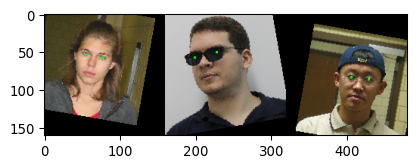

In [11]:
affine_params = dict(
    translate_percent=[-0.1, 0.1],
    rotate=[-10, 10],
    scale=[0.9, 1.1],
    order=0,
)

gen = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=3, **affine_params)
_, (images, _, landmarks) = gen.__getitem__(0)
print(images.shape, landmarks.shape)

draw_list = []
for im, landmark in zip(images, landmarks):
    kp = ia.KeypointsOnImage.from_xy_array((landmark * x_train.shape[1]).reshape(-1, 2), shape=im.shape)
    draw_list.append(kp.draw_on_image((im * 255).astype(np.uint8)[:, :, ::-1], size=3))

ia.imshow(np.hstack(draw_list))

# Model Training 

In [12]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc
}

best_model = load_model(FILE_BEST_MODEL, custom_objects=custom_objects)

for layer in best_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [13]:
def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [14]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_EYES = y_train_eyes.shape[1]

avg_pool = best_model.get_layer("global_average_pooling2d_1").output

avg_relu_1 = GlobalAvgPool2D(name="avg_relu_1")(best_model.get_layer("relu_1").output)
avg_relu_2 = GlobalAvgPool2D(name="avg_relu_2")(best_model.get_layer("relu_2").output)
avg_relu_3 = GlobalAvgPool2D(name="avg_relu_3")(best_model.get_layer("relu_3").output)
avg_relu_4 = GlobalAvgPool2D(name="avg_relu_4")(best_model.get_layer("relu_4").output)
emb_concat = Concatenate(name="emb_concat")([avg_relu_1, avg_relu_2, avg_relu_3, avg_relu_4, avg_pool])

dense_3 = dense_layer(3, emb_concat, 64)
dense_4 = dense_layer(4, dense_3, 32)
regress = Dense(units=N_EYES, activation='sigmoid', name='output_eyes')(dense_4)

model = Model(
    inputs=best_model.inputs,
    outputs=[
        best_model.get_layer("decoded").output,
        best_model.get_layer("outputs").output,
        regress
    ],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

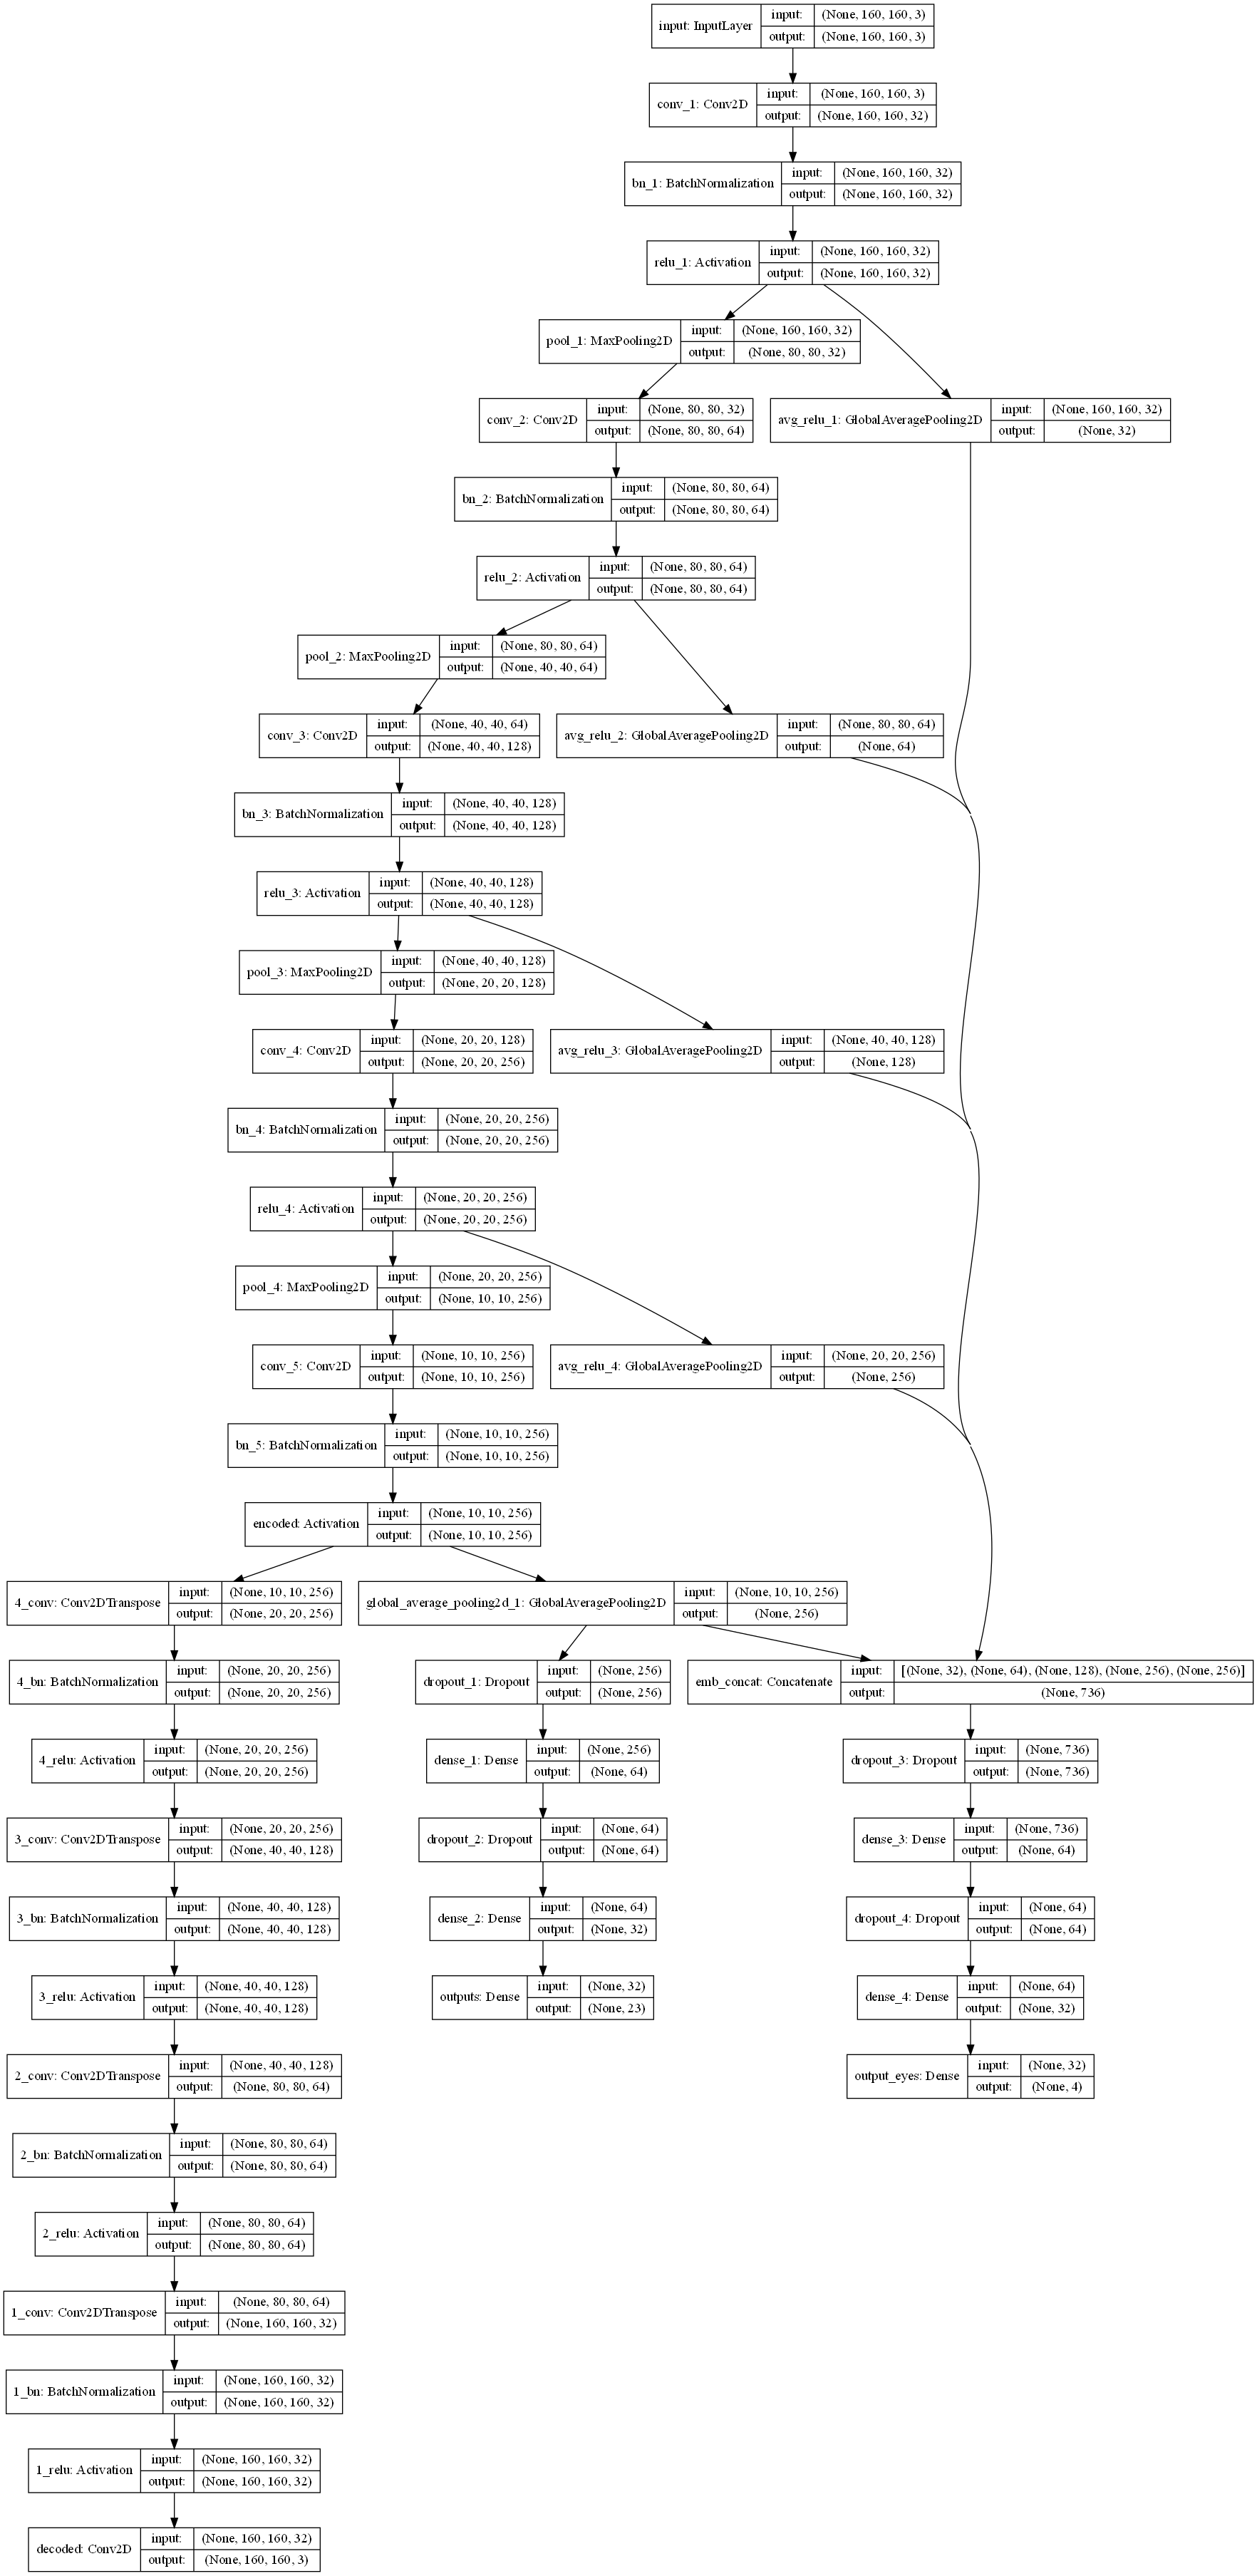

In [15]:
plot_model(model, show_shapes=True)

Epoch 1/100
100/100 [==============================] - 18s 184ms/step - loss: 31.1576 - decoded_loss: 0.0088 - outputs_loss: 0.3796 - output_eyes_loss: 31.1576 - outputs_accuracy: 0.8174 - outputs_precision: 0.9213 - outputs_recall: 0.8975 - outputs_f1: 0.9091 - outputs_fbeta: 0.8910 - outputs_specificity: 0.5571 - outputs_negative_predictive_value: 0.5014 - outputs_matthews_correlation_coefficient: 0.4352 - output_eyes_mae: 0.1009 - output_eyes_mse: 0.0168 - val_loss: 56.7700 - val_decoded_loss: 0.0095 - val_outputs_loss: 0.3285 - val_output_eyes_loss: 34.5797 - val_outputs_accuracy: 0.7964 - val_outputs_precision: 0.9349 - val_outputs_recall: 0.8720 - val_outputs_f1: 0.9022 - val_outputs_fbeta: 0.8682 - val_outputs_specificity: 0.6840 - val_outputs_negative_predictive_value: 0.5228 - val_outputs_matthews_correlation_coefficient: 0.5024 - val_output_eyes_mae: 0.0833 - val_output_eyes_mse: 0.0145

Epoch 00001: val_output_eyes_loss improved from inf to 34.57967, saving model to ../../mo

100/100 [==============================] - 15s 148ms/step - loss: 21.4964 - decoded_loss: 0.0088 - outputs_loss: 0.3925 - output_eyes_loss: 21.4964 - outputs_accuracy: 0.8152 - outputs_precision: 0.9195 - outputs_recall: 0.8964 - outputs_f1: 0.9077 - outputs_fbeta: 0.8894 - outputs_specificity: 0.5478 - outputs_negative_predictive_value: 0.4963 - outputs_matthews_correlation_coefficient: 0.4264 - output_eyes_mae: 0.0496 - output_eyes_mse: 0.0075 - val_loss: 18.0303 - val_decoded_loss: 0.0095 - val_outputs_loss: 0.3392 - val_output_eyes_loss: 34.5600 - val_outputs_accuracy: 0.7994 - val_outputs_precision: 0.9360 - val_outputs_recall: 0.8743 - val_outputs_f1: 0.9040 - val_outputs_fbeta: 0.8701 - val_outputs_specificity: 0.6940 - val_outputs_negative_predictive_value: 0.5315 - val_outputs_matthews_correlation_coefficient: 0.5133 - val_output_eyes_mae: 0.0564 - val_output_eyes_mse: 0.0114

Epoch 00009: val_output_eyes_loss did not improve from 30.61831
Epoch 10/100
100/100 [===============

100/100 [==============================] - 15s 147ms/step - loss: 19.7255 - decoded_loss: 0.0090 - outputs_loss: 0.3875 - output_eyes_loss: 19.7255 - outputs_accuracy: 0.8136 - outputs_precision: 0.9180 - outputs_recall: 0.8958 - outputs_f1: 0.9067 - outputs_fbeta: 0.8887 - outputs_specificity: 0.5439 - outputs_negative_predictive_value: 0.4941 - outputs_matthews_correlation_coefficient: 0.4225 - output_eyes_mae: 0.0391 - output_eyes_mse: 0.0069 - val_loss: 37.2546 - val_decoded_loss: 0.0094 - val_outputs_loss: 0.3043 - val_output_eyes_loss: 31.6518 - val_outputs_accuracy: 0.8009 - val_outputs_precision: 0.9363 - val_outputs_recall: 0.8761 - val_outputs_f1: 0.9051 - val_outputs_fbeta: 0.8720 - val_outputs_specificity: 0.6946 - val_outputs_negative_predictive_value: 0.5352 - val_outputs_matthews_correlation_coefficient: 0.5168 - val_output_eyes_mae: 0.0421 - val_output_eyes_mse: 0.0100

Epoch 00017: val_output_eyes_loss did not improve from 29.13413
Epoch 18/100
100/100 [===============

100/100 [==============================] - 15s 148ms/step - loss: 21.7169 - decoded_loss: 0.0087 - outputs_loss: 0.3805 - output_eyes_loss: 21.7169 - outputs_accuracy: 0.8166 - outputs_precision: 0.9191 - outputs_recall: 0.8986 - outputs_f1: 0.9087 - outputs_fbeta: 0.8914 - outputs_specificity: 0.5501 - outputs_negative_predictive_value: 0.5035 - outputs_matthews_correlation_coefficient: 0.4324 - output_eyes_mae: 0.0389 - output_eyes_mse: 0.0076 - val_loss: 4.8399 - val_decoded_loss: 0.0094 - val_outputs_loss: 0.3139 - val_output_eyes_loss: 30.6349 - val_outputs_accuracy: 0.7994 - val_outputs_precision: 0.9362 - val_outputs_recall: 0.8741 - val_outputs_f1: 0.9040 - val_outputs_fbeta: 0.8702 - val_outputs_specificity: 0.6986 - val_outputs_negative_predictive_value: 0.5332 - val_outputs_matthews_correlation_coefficient: 0.5170 - val_output_eyes_mae: 0.0414 - val_output_eyes_mse: 0.0106

Epoch 00025: val_output_eyes_loss did not improve from 28.42132
Epoch 26/100
100/100 [================

100/100 [==============================] - 15s 148ms/step - loss: 20.3103 - decoded_loss: 0.0089 - outputs_loss: 0.3821 - output_eyes_loss: 20.3103 - outputs_accuracy: 0.8173 - outputs_precision: 0.9202 - outputs_recall: 0.8980 - outputs_f1: 0.9089 - outputs_fbeta: 0.8913 - outputs_specificity: 0.5545 - outputs_negative_predictive_value: 0.5036 - outputs_matthews_correlation_coefficient: 0.4349 - output_eyes_mae: 0.0354 - output_eyes_mse: 0.0070 - val_loss: 37.5645 - val_decoded_loss: 0.0094 - val_outputs_loss: 0.3376 - val_output_eyes_loss: 28.9997 - val_outputs_accuracy: 0.8021 - val_outputs_precision: 0.9359 - val_outputs_recall: 0.8767 - val_outputs_f1: 0.9053 - val_outputs_fbeta: 0.8735 - val_outputs_specificity: 0.6920 - val_outputs_negative_predictive_value: 0.5347 - val_outputs_matthews_correlation_coefficient: 0.5157 - val_output_eyes_mae: 0.0429 - val_output_eyes_mse: 0.0099

Epoch 00033: val_output_eyes_loss did not improve from 25.98138
Epoch 34/100
100/100 [===============

100/100 [==============================] - 15s 148ms/step - loss: 18.7189 - decoded_loss: 0.0088 - outputs_loss: 0.3751 - output_eyes_loss: 18.7189 - outputs_accuracy: 0.8147 - outputs_precision: 0.9186 - outputs_recall: 0.8975 - outputs_f1: 0.9079 - outputs_fbeta: 0.8903 - outputs_specificity: 0.5489 - outputs_negative_predictive_value: 0.5010 - outputs_matthews_correlation_coefficient: 0.4298 - output_eyes_mae: 0.0345 - output_eyes_mse: 0.0064 - val_loss: 35.1022 - val_decoded_loss: 0.0094 - val_outputs_loss: 0.3598 - val_output_eyes_loss: 28.0621 - val_outputs_accuracy: 0.7973 - val_outputs_precision: 0.9344 - val_outputs_recall: 0.8720 - val_outputs_f1: 0.9020 - val_outputs_fbeta: 0.8687 - val_outputs_specificity: 0.6872 - val_outputs_negative_predictive_value: 0.5262 - val_outputs_matthews_correlation_coefficient: 0.5055 - val_output_eyes_mae: 0.0393 - val_output_eyes_mse: 0.0100

Epoch 00041: val_output_eyes_loss did not improve from 25.98138
Epoch 42/100
100/100 [===============

100/100 [==============================] - 15s 148ms/step - loss: 18.4766 - decoded_loss: 0.0087 - outputs_loss: 0.3915 - output_eyes_loss: 18.4766 - outputs_accuracy: 0.8154 - outputs_precision: 0.9193 - outputs_recall: 0.8960 - outputs_f1: 0.9074 - outputs_fbeta: 0.8895 - outputs_specificity: 0.5531 - outputs_negative_predictive_value: 0.4982 - outputs_matthews_correlation_coefficient: 0.4301 - output_eyes_mae: 0.0369 - output_eyes_mse: 0.0067 - val_loss: 26.2546 - val_decoded_loss: 0.0094 - val_outputs_loss: 0.3166 - val_output_eyes_loss: 29.0056 - val_outputs_accuracy: 0.8000 - val_outputs_precision: 0.9365 - val_outputs_recall: 0.8747 - val_outputs_f1: 0.9045 - val_outputs_fbeta: 0.8706 - val_outputs_specificity: 0.6913 - val_outputs_negative_predictive_value: 0.5295 - val_outputs_matthews_correlation_coefficient: 0.5113 - val_output_eyes_mae: 0.0381 - val_output_eyes_mse: 0.0098

Epoch 00049: val_output_eyes_loss did not improve from 25.98138
Epoch 50/100
100/100 [===============

100/100 [==============================] - 15s 149ms/step - loss: 18.4010 - decoded_loss: 0.0087 - outputs_loss: 0.3881 - output_eyes_loss: 18.4010 - outputs_accuracy: 0.8158 - outputs_precision: 0.9193 - outputs_recall: 0.8974 - outputs_f1: 0.9081 - outputs_fbeta: 0.8905 - outputs_specificity: 0.5492 - outputs_negative_predictive_value: 0.4988 - outputs_matthews_correlation_coefficient: 0.4289 - output_eyes_mae: 0.0351 - output_eyes_mse: 0.0066 - val_loss: 4.8041 - val_decoded_loss: 0.0094 - val_outputs_loss: 0.3351 - val_output_eyes_loss: 30.8412 - val_outputs_accuracy: 0.7993 - val_outputs_precision: 0.9353 - val_outputs_recall: 0.8750 - val_outputs_f1: 0.9041 - val_outputs_fbeta: 0.8717 - val_outputs_specificity: 0.6900 - val_outputs_negative_predictive_value: 0.5329 - val_outputs_matthews_correlation_coefficient: 0.5122 - val_output_eyes_mae: 0.0397 - val_output_eyes_mse: 0.0104

Epoch 00057: val_output_eyes_loss did not improve from 25.98138
Restoring model weights from the end o

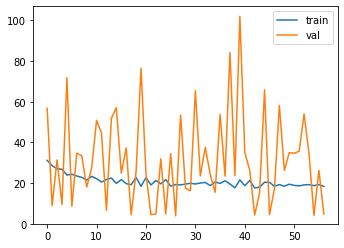

In [16]:
DECODED_LOSS_WEIGHT = 0.0
REQS_LOSS_WEIGHT = 0.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy",
    "output_eyes": "mean_absolute_percentage_error"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae", "mse"]
}
METRIC_TO_MONITOR = "val_output_eyes_loss"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="min", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="min", patience=30, verbose=1, restore_best_weights=True)
]

affine_params = dict(
    translate_percent=[-0.1, 0.1],
    rotate=[-10, 10],
    scale=[0.9, 1.1],
    order=0,
)

gen_train = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=32, **affine_params)
gen_valid = ImageLandmarkGenerator(x_val, y_val_reqs, y_val_eyes, batch_size=32, **affine_params)

hist = model.fit_generator(
    gen_train,
    steps_per_epoch=100,
    epochs=100,
    validation_data=gen_valid,
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

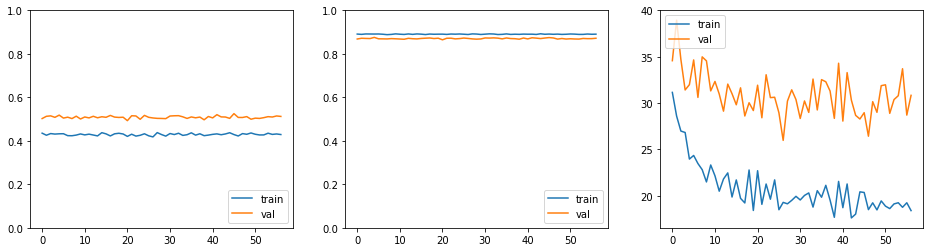

In [17]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history['output_eyes_loss'], label='train')
plt.plot(history['val_output_eyes_loss'], label='val')
plt.legend(loc='upper left')

# Test Model

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
[[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]]
[68.  75.  89.5 74. ]
[52.3489   56.339226 75.55236  57.097984]


Text(0.5, 1.0, 'decoded image')

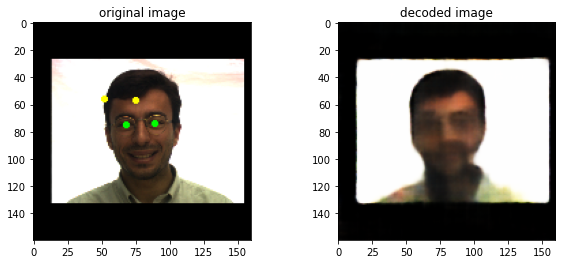

In [18]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx]

y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im / 255)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)
y_pred_eyes = (y_pred_eyes * im.shape[1]).flatten()

print(y_true_reqs, y_pred_reqs, sep='\n')
print(y_true_eyes, y_pred_eyes, sep='\n')

im = im.squeeze()[:, :, ::-1].astype(np.uint8)
true_r = tuple(y_true_eyes[:2].astype(np.int))
true_l = tuple(y_true_eyes[2:].astype(np.int))
pred_r = tuple(y_pred_eyes[:2].astype(np.int))
pred_l = tuple(y_pred_eyes[2:].astype(np.int))
cv2.circle(im, true_r, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, true_l, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, pred_r, radius=1, color=(255, 255, 0), thickness=2)
cv2.circle(im, pred_l, radius=1, color=(255, 255, 0), thickness=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [19]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('outputs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2022_05_28-10_39_38.h5
Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
__________________________

In [20]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

../../data/cropped_faces/images/afwDB_0.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Reqs:
0.64809215
0.9347415
0.99573874
0.08281669
0.991169
0.9998725
0.9772672
0.27883732
0.96358013
0.053408027
0.20580012
0.14253017
0.9828384
0.47127613
0.8292506
0.99030715
0.7546116
0.97962976
0.89305204
0.65849125
0.9751568
0.82795393
0.9905076

Eyes:
0.3256427
0.35060596
0.47139353
0.35144672


# Embeddings Visualization 

In [21]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [22]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = dataset.images[x_val_idx]
mrks = dataset.mrks[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

586
(586, 160, 160, 3)


In [23]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [24]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [25]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

(4000, 4000, 3)


### Embeddings 

In [26]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

In [27]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

(586, 256)


### Tensorboard 

In [28]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [29]:
mlflow.end_run()